# Neural Network Classification 

In [27]:
import sklearn
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from torch import nn
import requests
import numpy as np
from sklearn.datasets import make_blobs
import torchmetrics

## create classification data

In [2]:
#make 1000 samples
n_samples = 1000

In [3]:
#create circles
from torch import rand


x, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [4]:
len(x), len(y)

(1000, 1000)

In [5]:
#make dataframe of circle data
circles = pd.DataFrame({"x1": x[:, 0],
                        "x2": x[:, 1],
                        "label": y})
circles.head(10)

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


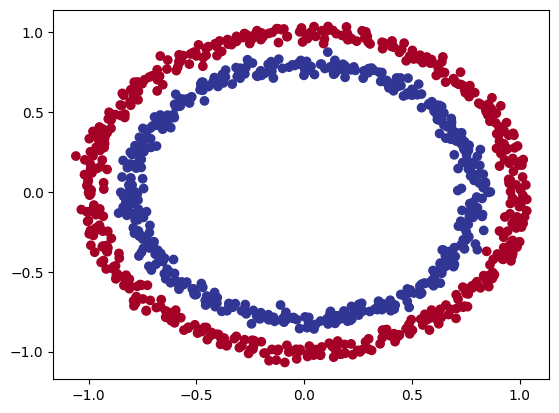

In [6]:
#visualise
plt.scatter(x=x[:, 0],
            y=x[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

## check input and output

In [7]:
x.shape, y.shape

((1000, 2), (1000,))

In [8]:
#view first sample
x_sample = x[0]
y_sample = y[0]

print(f"{x_sample}, {y_sample}")

[0.75424625 0.23148074], 1


## turn data into tensors

In [9]:
#turn data into tensors
X = torch.from_numpy(x).type(torch.float)
Y = torch.from_numpy(y).type(torch.float)

X[:5], Y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
X.shape, Y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [11]:
#split into train / test
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

len(X_train), len(X_test)

(800, 200)

## build model

In [12]:
class CircleModelV0(nn.Module):

    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=5)     # input layer
        self.layer_2 = nn.Linear(in_features=5, out_features=1)     # hidden layer


    def forward(self, x):
        return self.layer_2(self.layer_1(x))

In [13]:
#instantiate
model_1 = CircleModelV0()
model_1

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
#same model with nn.Sequential()
model_2 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)

model_2

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
model_2.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.3162,  0.2800],
                      [-0.1265, -0.4223],
                      [-0.1735, -0.4886],
                      [ 0.5098, -0.6518],
                      [ 0.0419, -0.1284]])),
             ('0.bias', tensor([-0.2447,  0.3109,  0.0244,  0.2727,  0.0954])),
             ('1.weight',
              tensor([[ 0.2435,  0.3926, -0.2448,  0.2722,  0.4303]])),
             ('1.bias', tensor([0.1245]))])

In [16]:
#make predictions
with torch.inference_mode():
    untrained_pred = model_2(X_test)
    print(f"len = {len(untrained_pred.round().abs())}, shape = {untrained_pred.shape}")
    print(f"len = {len(X_test)}, shape = {X_test.shape}")
    print(untrained_pred[:10].round().abs())
    print(Y_test[:10])

len = 200, shape = torch.Size([200, 1])
len = 200, shape = torch.Size([200, 2])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.]])
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## setup loss function and optimizer

In [17]:
#for classification, best loss funcs are adam, BCE and SGD for optim
loss_fn = nn.BCEWithLogitsLoss()

In [18]:
#create optimizer
optimizer = torch.optim.SGD(params=model_2.parameters(),
                           lr=0.1)

In [19]:
#calculate accuracy (what % is correct)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## train model

In [20]:
# view first 5 outputs
model_2.eval()
with torch.inference_mode():
    y_logits = model_2(X_test[:5])
y_logits

tensor([[0.0674],
        [0.0975],
        [0.2033],
        [0.0280],
        [0.5442]])

In [21]:
#use sigmoid activation function
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5169],
        [0.5244],
        [0.5507],
        [0.5070],
        [0.6328]])

In [22]:
#find predicted labels
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_2(X_test[:5])))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

In [23]:
Y_test[:5]

tensor([1., 0., 1., 0., 1.])

## build train and test loop

In [24]:
torch.manual_seed(1)

epochs = 1000

for epoch in range(epochs):

    model_2.train()

    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits,
                   Y_train)

    acc = accuracy_fn(y_true=Y_train,
                      y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_2.eval()

    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()

        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, Y_test)

        test_acc = accuracy_fn(y_true=Y_test, y_pred=test_pred)

        if epoch % 10 == 0:
            print(f"epoch: {epoch} | loss: {loss:.5f} | acc: {acc:.2f}% | test_loss: {test_loss:.5f} | test_acc: {test_acc:.2f}%")

epoch: 0 | loss: 0.70981 | acc: 54.75% | test_loss: 0.70451 | test_acc: 54.50%
epoch: 10 | loss: 0.70101 | acc: 54.12% | test_loss: 0.69850 | test_acc: 56.00%
epoch: 20 | loss: 0.69726 | acc: 52.00% | test_loss: 0.69629 | test_acc: 54.00%
epoch: 30 | loss: 0.69555 | acc: 50.88% | test_loss: 0.69549 | test_acc: 55.00%
epoch: 40 | loss: 0.69469 | acc: 50.38% | test_loss: 0.69521 | test_acc: 53.50%
epoch: 50 | loss: 0.69421 | acc: 50.00% | test_loss: 0.69513 | test_acc: 52.00%
epoch: 60 | loss: 0.69392 | acc: 49.88% | test_loss: 0.69510 | test_acc: 52.00%
epoch: 70 | loss: 0.69372 | acc: 50.00% | test_loss: 0.69510 | test_acc: 49.50%
epoch: 80 | loss: 0.69357 | acc: 50.38% | test_loss: 0.69510 | test_acc: 49.50%
epoch: 90 | loss: 0.69346 | acc: 50.38% | test_loss: 0.69510 | test_acc: 49.00%
epoch: 100 | loss: 0.69337 | acc: 50.50% | test_loss: 0.69509 | test_acc: 49.00%
epoch: 110 | loss: 0.69330 | acc: 50.88% | test_loss: 0.69509 | test_acc: 49.00%
epoch: 120 | loss: 0.69324 | acc: 50.00

## visualize

In [25]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

NameError: name 'model_3' is not defined

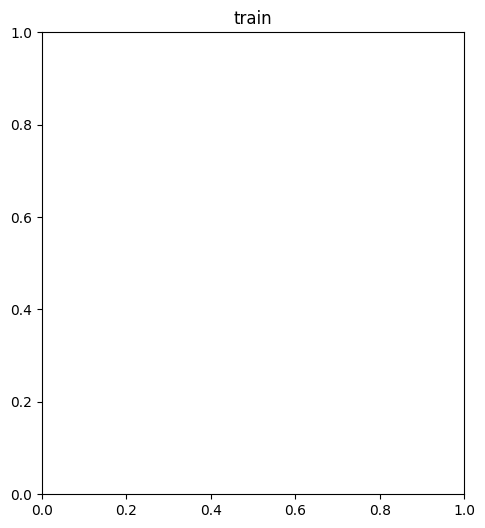

In [26]:
#plot decision boundary of model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_3, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_3, X_test, Y_test)


## improve model

possibilities

* add more layers
* add more hidden units
* learn for longer
* change the activation function
* change the learning rate
* change the loss function

In [ ]:
class CircleModelV1(nn.Module):

    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_3 = CircleModelV1()

In [ ]:
#create loss func
loss_fn = nn.BCEWithLogitsLoss()

#create optimizer
optimizer = torch.optim.SGD(params=model_3.parameters(),
                           lr=0.1)

In [ ]:
torch.manual_seed(1)

epochs = 1000

for epoch in range(epochs):

    model_3.train()

    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits,
                   Y_train)

    acc = accuracy_fn(y_true=Y_train,
                      y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_3.eval()

    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()

        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, Y_test)

        test_acc = accuracy_fn(y_true=Y_test, y_pred=test_pred)

        if epoch % 100 == 0:
            print(f"epoch: {epoch} | loss: {loss:.5f} | acc: {acc:.2f}% | test_loss: {test_loss:.5f} | test_acc: {test_acc:.2f}%")

epoch: 0 | loss: 0.69299 | acc: 51.50% | test_loss: 0.69438 | test_acc: 46.00%
epoch: 100 | loss: 0.69298 | acc: 51.62% | test_loss: 0.69443 | test_acc: 45.50%
epoch: 200 | loss: 0.69298 | acc: 51.38% | test_loss: 0.69447 | test_acc: 44.50%
epoch: 300 | loss: 0.69298 | acc: 51.50% | test_loss: 0.69451 | test_acc: 44.50%
epoch: 400 | loss: 0.69298 | acc: 51.62% | test_loss: 0.69454 | test_acc: 45.00%
epoch: 500 | loss: 0.69298 | acc: 51.38% | test_loss: 0.69457 | test_acc: 45.00%
epoch: 600 | loss: 0.69298 | acc: 51.38% | test_loss: 0.69459 | test_acc: 45.00%
epoch: 700 | loss: 0.69298 | acc: 51.38% | test_loss: 0.69460 | test_acc: 45.00%
epoch: 800 | loss: 0.69298 | acc: 51.25% | test_loss: 0.69462 | test_acc: 45.00%
epoch: 900 | loss: 0.69298 | acc: 51.25% | test_loss: 0.69463 | test_acc: 45.00%


## test if model can learn linear relationships

In [ ]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)

y_regression = weight * X_regression + bias

#check data
print(len(X_regression))


100


In [ ]:
#train and test split

train_split = int(0.8 * len(X_regression))
X_train_r, y_train_r = X_regression[:train_split], y_regression[:train_split]
X_test_r, y_test_r = X_regression[train_split:], y_regression[train_split:]

len(X_train_r), len(X_test_r)

(80, 20)

In [ ]:
# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

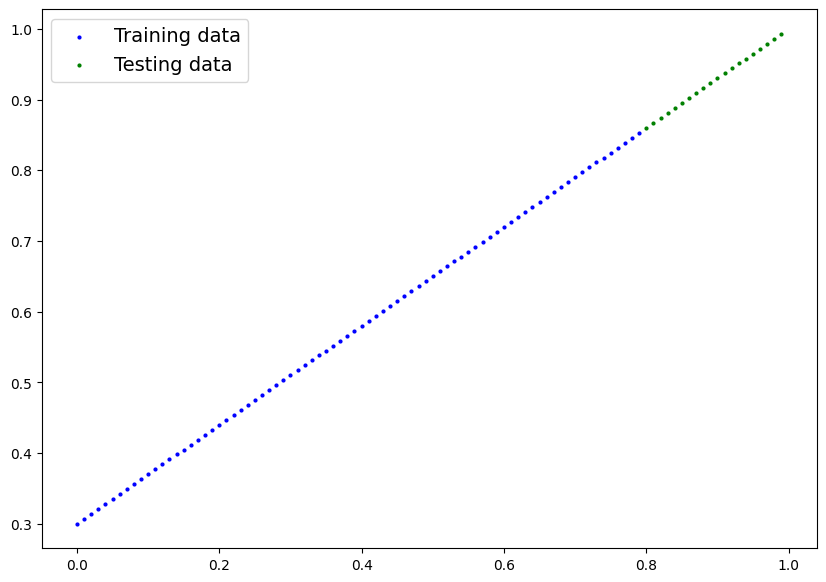

In [ ]:
plot_predictions(train_data=X_train_r,
                 train_labels=y_train_r,
                 test_data=X_test_r,
                 test_labels=y_test_r)

In [ ]:
class CircleModelV1_1(nn.Module):

    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=1, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_3_1 = CircleModelV1_1()

In [ ]:
#create loss func
loss_fn = nn.L1Loss()

#create optimizer
optimizer = torch.optim.SGD(params=model_3_1.parameters(),
                           lr=0.01)

In [ ]:
torch.manual_seed(1)

epochs = 1000

for epoch in range(epochs):

    y_pred = model_3_1(X_train_r)

    loss = loss_fn(y_pred,
                   y_train_r)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_3_1.eval()

    with torch.inference_mode():

        test_pred = model_3_1(X_test_r)

        test_loss = loss_fn(test_pred, y_test_r)


        if epoch % 100 == 0:
            print(f"epoch: {epoch} | loss: {loss:.5f} | test_loss: {test_loss:.5f}")

epoch: 0 | loss: 0.05277 | test_loss: 0.03230
epoch: 100 | loss: 0.00618 | test_loss: 0.01136
epoch: 200 | loss: 0.00604 | test_loss: 0.01465
epoch: 300 | loss: 0.00605 | test_loss: 0.01453
epoch: 400 | loss: 0.00606 | test_loss: 0.01441
epoch: 500 | loss: 0.00607 | test_loss: 0.01429
epoch: 600 | loss: 0.00576 | test_loss: 0.01415
epoch: 700 | loss: 0.00577 | test_loss: 0.01469
epoch: 800 | loss: 0.00608 | test_loss: 0.01456
epoch: 900 | loss: 0.00609 | test_loss: 0.01441


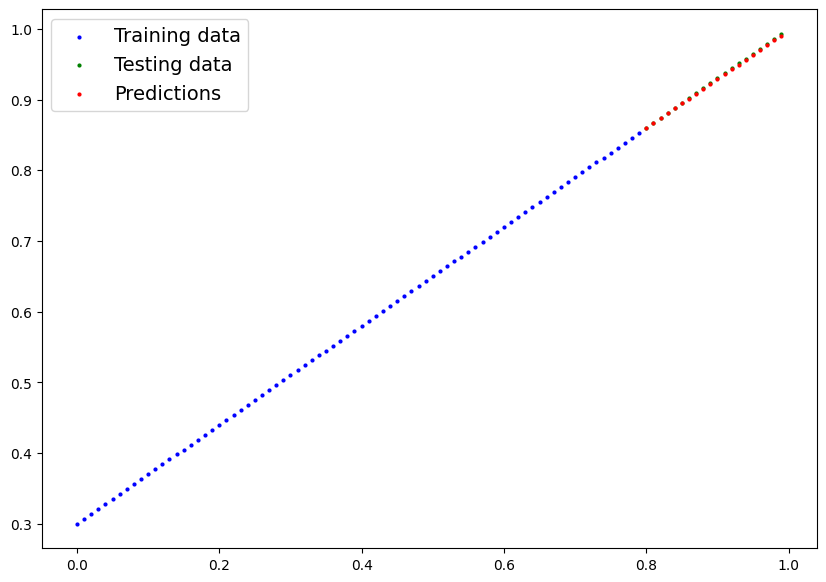

In [ ]:
model_3_1.eval()

with torch.inference_mode():
    y_preds = model_3_1(X_test_r)

plot_predictions(train_data=X_train_r,
                 train_labels=y_train_r,
                 test_data=X_test_r,
                 test_labels=y_test_r,
                 predictions=y_preds)

## non-linear functions

In [ ]:
class CircleModelV2(nn.Module):

    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_4 = CircleModelV2()

In [ ]:
#create optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(),
                           lr=0.5)

#create loss func
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
torch.manual_seed(1)

epochs = 1000

for epoch in range(epochs):

    model_4.train()

    y_logits = model_4(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits,
                   Y_train)

    acc = accuracy_fn(y_true=Y_train,
                      y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_4.eval()

    with torch.inference_mode():
        test_logits = model_4(X_test).squeeze()

        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, Y_test)

        test_acc = accuracy_fn(y_true=Y_test, y_pred=test_pred)

        if epoch % 100 == 0:
            print(f"epoch: {epoch} | loss: {loss:.5f} | acc: {acc:.2f}% | test_loss: {test_loss:.5f} | test_acc: {test_acc:.2f}%")

epoch: 0 | loss: 0.67874 | acc: 56.75% | test_loss: 0.67376 | test_acc: 64.50%
epoch: 100 | loss: 0.52415 | acc: 91.50% | test_loss: 0.54500 | test_acc: 85.50%
epoch: 200 | loss: 0.51251 | acc: 65.62% | test_loss: 0.59041 | test_acc: 65.50%
epoch: 300 | loss: 0.40621 | acc: 73.00% | test_loss: 0.49425 | test_acc: 66.00%
epoch: 400 | loss: 0.05986 | acc: 100.00% | test_loss: 0.08504 | test_acc: 98.50%
epoch: 500 | loss: 0.02895 | acc: 100.00% | test_loss: 0.04873 | test_acc: 99.00%
epoch: 600 | loss: 0.01959 | acc: 100.00% | test_loss: 0.03690 | test_acc: 99.00%
epoch: 700 | loss: 0.01485 | acc: 100.00% | test_loss: 0.03118 | test_acc: 99.00%
epoch: 800 | loss: 0.01214 | acc: 100.00% | test_loss: 0.02778 | test_acc: 99.00%
epoch: 900 | loss: 0.01008 | acc: 100.00% | test_loss: 0.02560 | test_acc: 99.00%


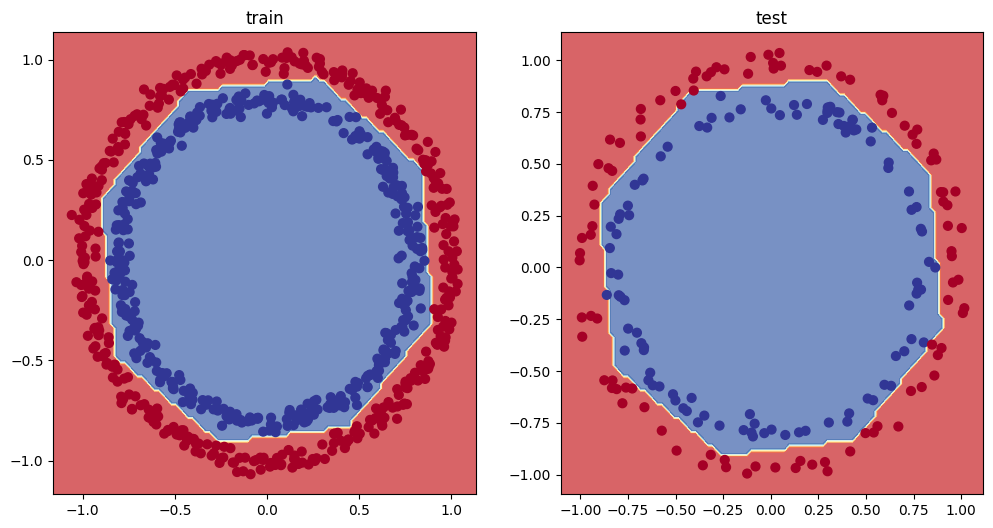

In [ ]:
#plot decision boundary of model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_4, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_4, X_test, Y_test)

## replicate non-linear activation functions

In [ ]:
A = torch.arange(-10., 10., 1.)
A.dtype

torch.float32

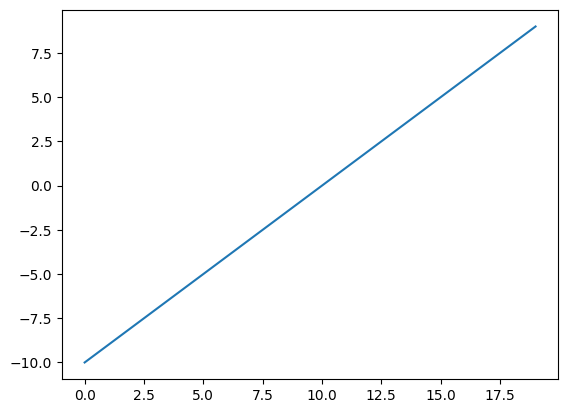

In [ ]:
plt.plot(A)

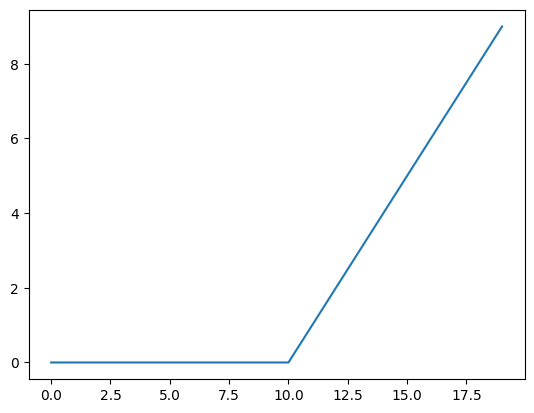

In [ ]:
plt.plot(torch.relu(A))

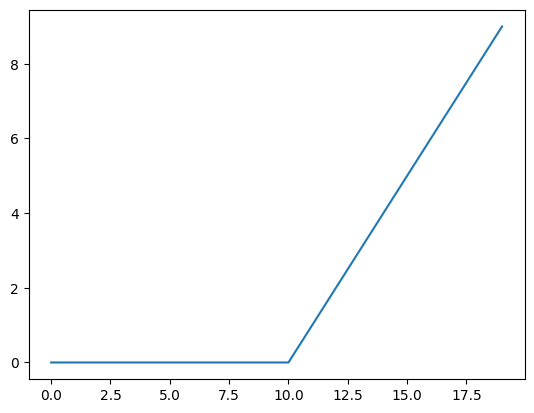

In [ ]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)

plt.plot(relu(A))

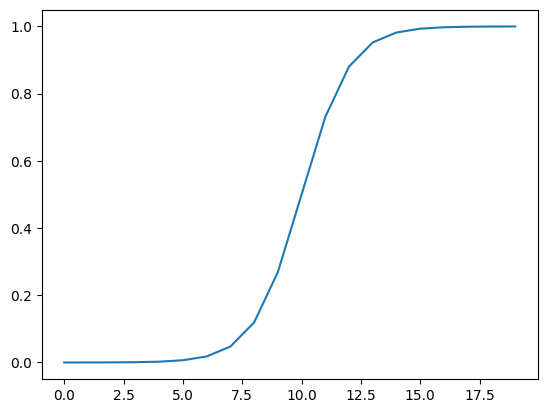

In [ ]:
plt.plot(torch.sigmoid(A))

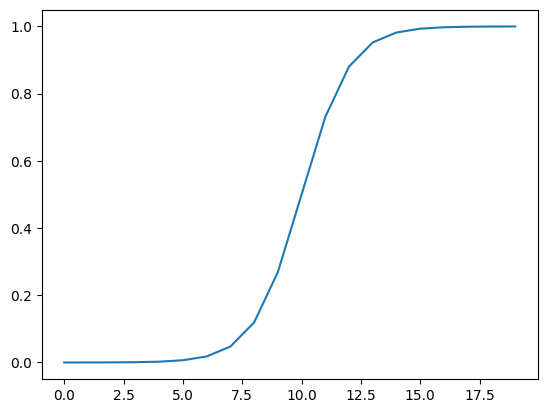

In [ ]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

plt.plot(sigmoid(A))

## multi-class classification

In [28]:
# create dataset

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [48]:
#create data
x_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

In [49]:
#turn data into tensors
x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

In [50]:
#train test split
x_blob_t, x_blob_test, y_blob_t, y_blob_test = train_test_split(x_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

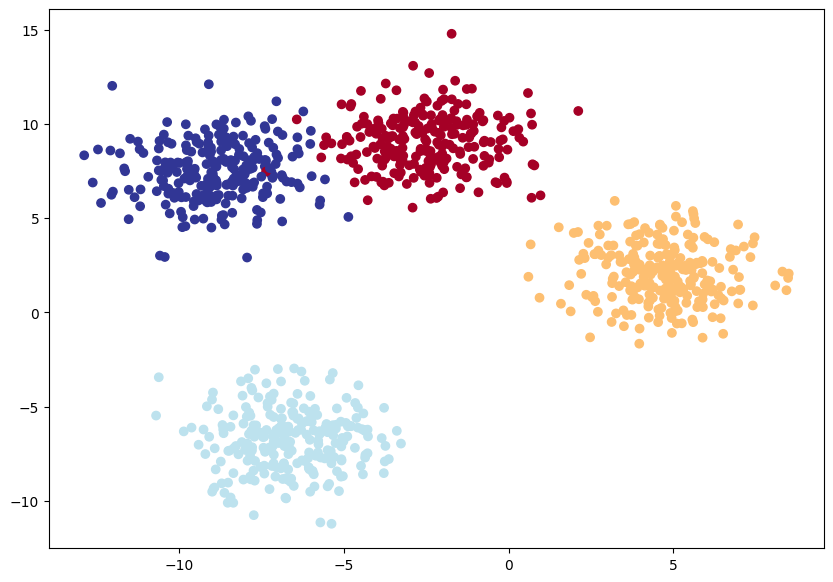

In [51]:
#plot data
plt.figure(figsize=(10, 7))
plt.scatter(x_blob[:, 0], x_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [52]:
#build model


class BlobModelV0(nn.Module):

    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model_5 = BlobModelV0(input_features=2, output_features=4)

In [53]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_5.parameters(), lr=0.1)

In [54]:
#see current outputs
model_5.eval()

with torch.inference_mode():
    y_logits = model_5(x_blob_test)
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_preds = torch.argmax(y_pred_probs, dim=1)
    print(y_preds[:10])




tensor([0, 2, 2, 0, 0, 2, 2, 0, 2, 0])


In [56]:
#training loop
epochs = 5000

for epoch in range(epochs):
    model_5.train()

    y_logits = model_5(x_blob_t)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_t)

    acc = accuracy_fn(y_true=y_blob_t, y_pred=y_preds)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    model_5.eval()
    with torch.inference_mode():
        test_logits = model_5(x_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)

        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

        if epoch % 100 == 0:
            print(f"epoch = {epoch}")
            print(f"loss = {loss:4f} | acc = {acc:2f} | test loss = {test_loss:4f} | test acc = {test_acc:2f}")


epoch = 0
loss = 0.022898 | acc = 99.375000 | test loss = 0.011334 | test acc = 99.500000
epoch = 100
loss = 0.022650 | acc = 99.375000 | test loss = 0.011064 | test acc = 99.500000
epoch = 200
loss = 0.022405 | acc = 99.500000 | test loss = 0.010819 | test acc = 99.500000
epoch = 300
loss = 0.022174 | acc = 99.500000 | test loss = 0.010583 | test acc = 99.500000
epoch = 400
loss = 0.021955 | acc = 99.500000 | test loss = 0.010356 | test acc = 99.500000
epoch = 500
loss = 0.021746 | acc = 99.500000 | test loss = 0.010139 | test acc = 99.500000
epoch = 600
loss = 0.021545 | acc = 99.500000 | test loss = 0.009930 | test acc = 99.500000
epoch = 700
loss = 0.021351 | acc = 99.500000 | test loss = 0.009729 | test acc = 99.500000
epoch = 800
loss = 0.021164 | acc = 99.500000 | test loss = 0.009535 | test acc = 99.500000
epoch = 900
loss = 0.020982 | acc = 99.500000 | test loss = 0.009345 | test acc = 99.500000
epoch = 1000
loss = 0.020807 | acc = 99.500000 | test loss = 0.009162 | test acc =

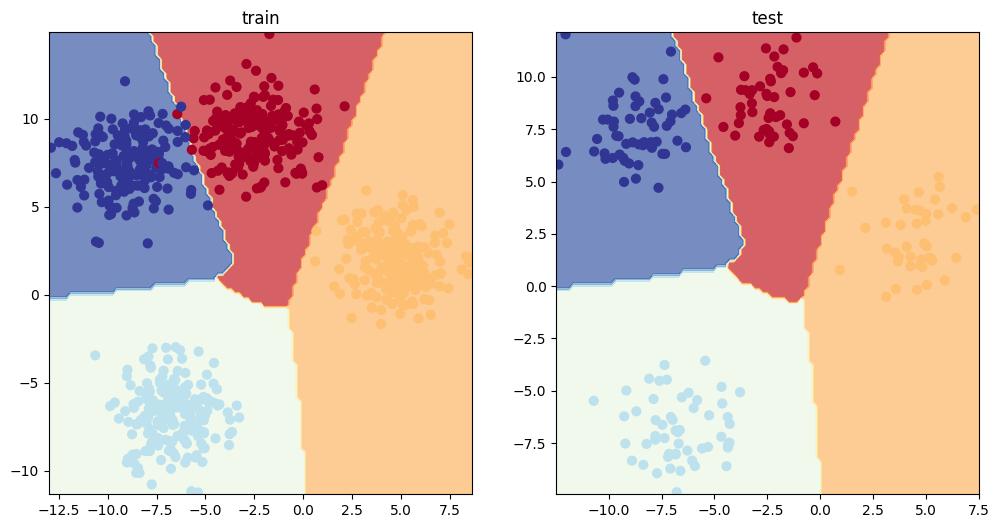

In [58]:
# visualize

model_5.eval()
with torch.inference_mode():
    y_logits = model_5(x_blob_test)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_5, x_blob_t, y_blob_t)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_5, x_blob_test, y_blob_test)